<a href="https://colab.research.google.com/github/RafaelSigmoidal/Desastres-Ambientais-com-Vis-o-Computacional/blob/main/Landsat_8_e_o_Monitoramento_da_Degrada%C3%A7%C3%A3o_Vegetal_em_Brumadinho_Uma_An%C3%A1lise_P%C3%B3s_Cat%C3%A1strofe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importamos as bibliotecas necessárias
import ee
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Esta linha permite que os gráficos sejam exibidos diretamente no notebook
%matplotlib inline

# Configuramos a biblioteca matplotlib para usar 'gray' como o mapa de cores padrão para imagens
plt.rcParams['image.cmap'] = 'gray'

# Importamos a biblioteca gdal da osgeo, usada para manipular arquivos geoespaciais
from osgeo import gdal

In [ ]:
# disparar o fluxo de autenticação
ee.Authenticate()

# inicializar a biblioteca
ee.Initialize(project='mapeamento-436102')

In [ ]:
print(ee.Image("NASA/NASADEM_HGT/001").get("title").getInfo())

NASADEM: NASA NASADEM Digital Elevation 30m


In [ ]:
ee.Image('LANDSAT/LC08/C02/T1_L2/LC08_044034_20201028')

In [ ]:
def cloud_mask_l8(image):
    qa = image.select('QA_PIXEL')

    # Bits 3 and 5 are cloud shadow and cloud, respectively.
    cloudShadowBitMask = 1 << 3
    cloudsBitMask = 1 << 5

    # Both flags should be set to zero, indicating clear conditions.
    mask = qa.bitwiseAnd(cloudShadowBitMask).eq(0) \
             .And(qa.bitwiseAnd(cloudsBitMask).eq(0))

    return image.updateMask(mask)

In [ ]:
# Importa a coleção USGS Landsat 8 Level 2, Collection 2, Tier 1
# lc = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')

# Define um polígono em torno barragem Brumadinho, Minas Gerais.
geometry = ee.Geometry.Polygon(
    [[  [-44.178758769406954,
              -20.099169793097772],
        [-44.178758769406954,
              -20.156180019826365],
        [ -44.07816332716345,
              -20.156180019826365],
        [ -44.07816332716345,
              -20.099169793097772]]],
        None,
        False)

# Define os parâmetros para Landsat8.
landsat8_params = {
  "bands": ['SR_B4', 'SR_B3', 'SR_B2'],
  "min": 0.0,
  "max": 30000.0,
  "gamma": 1.0
}

# Filtra a imagem da coleção do Landsat 8 pelo periodo antes da Queimadas e aplica a máscara de nuvens.
dataset15 = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2').filterDate('2015-01-01', '2015-12-31').map(cloud_mask_l8)
lansat15 = dataset15.median().clip(geometry)

# Filtra a imagem da coleção do Landsat 8 pelo periodo Durante as Queimadas e aplica a máscara de nuvens.
dataset19 = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2').filterDate('2019-01-01', '2019-12-31').map(cloud_mask_l8)
lansat19 = dataset19.median().clip(geometry)

# Filtra a imagem da coleção do Landsat 8 pelo periodo Apos as Queiadas da Queimadas e aplica a máscara de nuvens.
dataset24 = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2').filterDate('2024-01-01', '2024-12-31').map(cloud_mask_l8)
lansat24 = dataset24.median().clip(geometry)


In [ ]:
import folium

def add_ee_layer(self, ee_image_object, vis_params, name):
    """
    Adiciona uma camada de imagem do Google Earth Engine a um mapa do folium.

    Args:
        self (object): Objeto do mapa folium ao qual a camada será adicionada.
        ee_image_object (ee.image.Image): Imagem do Google Earth Engine para ser adicionada ao mapa folium.
        vis_params (dict): Parâmetros de visualização para a imagem.
            Este dicionário deve conter pelo menos uma propriedade 'bands'.
            Por exemplo, { 'bands': ['SR_B4', 'SR_B3', 'SR_B2'], 'max': 0.3 }.
        name (str): Nome da camada que será adicionada.

    Retorna:
        None

    Exemplo:
        # Define um mapa folium
        mapa = folium.Map(location=[-15.783333, -47.866667], zoom_start=12)

        # Imagem do GEE
        imagem = ee.Image('LANDSAT/LC08/C01/T1_SR/LC08_220071_20170805')

        # Parâmetros de visualização
        vis = { 'bands': ['B4', 'B3', 'B2'], 'max': 0.3 }

        # Adicione a imagem ao mapa
        mapa.add_ee_layer(imagem, vis, 'Brasilia Landsat')

        # Exibe o mapa
        display(mapa)

    """
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
        name=name,
        overlay=True,
        control=True
    ).add_to(self)

# Adiciona o método de desenho do Google Earth Engine ao folium.
folium.Map.add_ee_layer = add_ee_layer

# Centraliza o mapa em Brumadinho, Minas Gerais
map = folium.Map(location = (-20.132240, -44.121695), zoom_start = 12)

# Adicionando as imagens geradas ao mapa.
map.add_ee_layer(lansat15, landsat8_params, '2015')
map.add_ee_layer(lansat19, landsat8_params, '2019')
map.add_ee_layer(lansat24, landsat8_params, '2024')

# Adiciona um painel de controle de camadas ao mapa.
map.add_child(folium.LayerControl())

# Exibe o mapa.
display(map)

In [ ]:
# Define um polígono com base nas novas coordenadas
geometry = ee.Geometry.Polygon(
    [[  [-44.178758769406954,
              -20.099169793097772],
        [-44.178758769406954,
              -20.156180019826365],
        [-44.07816332716345,
              -20.156180019826365],
        [ -44.07816332716345,
              -20.099169793097772]]],
        None,
        False)

# Define os parâmetros para Landsat8.
landsat8_params = {
  "bands": ['SR_B4', 'SR_B3', 'SR_B2'],
  "min": 0.0,
  "max": 30000.0,
  "gamma": 1.0
}

# Filtra a imagem da coleção do Landsat 8 pelo ano de 2013 e aplica a máscara de nuvens.
dataset13 = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2').filterDate('2015-01-01', '2015-12-31').map(cloud_mask_l8)
lansat13 = dataset13.median().clip(geometry)

# Filtra a imagem da coleção do Landsat 8 pelo ano de 2018 e aplica a máscara de nuvens.
dataset18 = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2').filterDate('2019-01-01', '2019-12-31').map(cloud_mask_l8)
lansat18 = dataset18.median().clip(geometry)

# Filtra a imagem da coleção do Landsat 8 pelo ano de 2023 e aplica a máscara de nuvens.
dataset23 = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2').filterDate('2024-01-01', '2024-12-31').map(cloud_mask_l8)
lansat23 = dataset23.median().clip(geometry)

In [ ]:
task_config = {
  'folder': 'deforestation',
  'scale': 30,
  'region': geometry,
  'fileFormat': 'GeoTIFF',
  'maxPixels': 1e9,
  'formatOptions': {
    'cloudOptimized': True
  }
}

task1 = ee.batch.Export.image.toDrive(lansat13, description= '2015api', **task_config)
task2 = ee.batch.Export.image.toDrive(lansat18, description= '2019api', **task_config)
task3 = ee.batch.Export.image.toDrive(lansat23, description= '2023api', **task_config)

In [ ]:
task1.start()
task2.start()
task3.start()

In [ ]:
task1.status()

{'state': 'READY',
 'description': '2015api',
 'priority': 100,
 'creation_timestamp_ms': 1727410736692,
 'update_timestamp_ms': 1727410736692,
 'start_timestamp_ms': 0,
 'task_type': 'EXPORT_IMAGE',
 'id': '6TK672E7KKYXLMLYAC4DJIW6',
 'name': 'projects/mapeamento-436102/operations/6TK672E7KKYXLMLYAC4DJIW6'}

In [ ]:
task1.status()

{'state': 'READY',
 'description': '2015api',
 'priority': 100,
 'creation_timestamp_ms': 1727410736692,
 'update_timestamp_ms': 1727410736692,
 'start_timestamp_ms': 0,
 'task_type': 'EXPORT_IMAGE',
 'id': '6TK672E7KKYXLMLYAC4DJIW6',
 'name': 'projects/mapeamento-436102/operations/6TK672E7KKYXLMLYAC4DJIW6'}

In [ ]:
task1.status()

{'state': 'RUNNING',
 'description': '2015api',
 'priority': 100,
 'creation_timestamp_ms': 1727410736692,
 'update_timestamp_ms': 1727410744143,
 'start_timestamp_ms': 1727410744031,
 'task_type': 'EXPORT_IMAGE',
 'attempt': 1,
 'id': '6TK672E7KKYXLMLYAC4DJIW6',
 'name': 'projects/mapeamento-436102/operations/6TK672E7KKYXLMLYAC4DJIW6'}

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


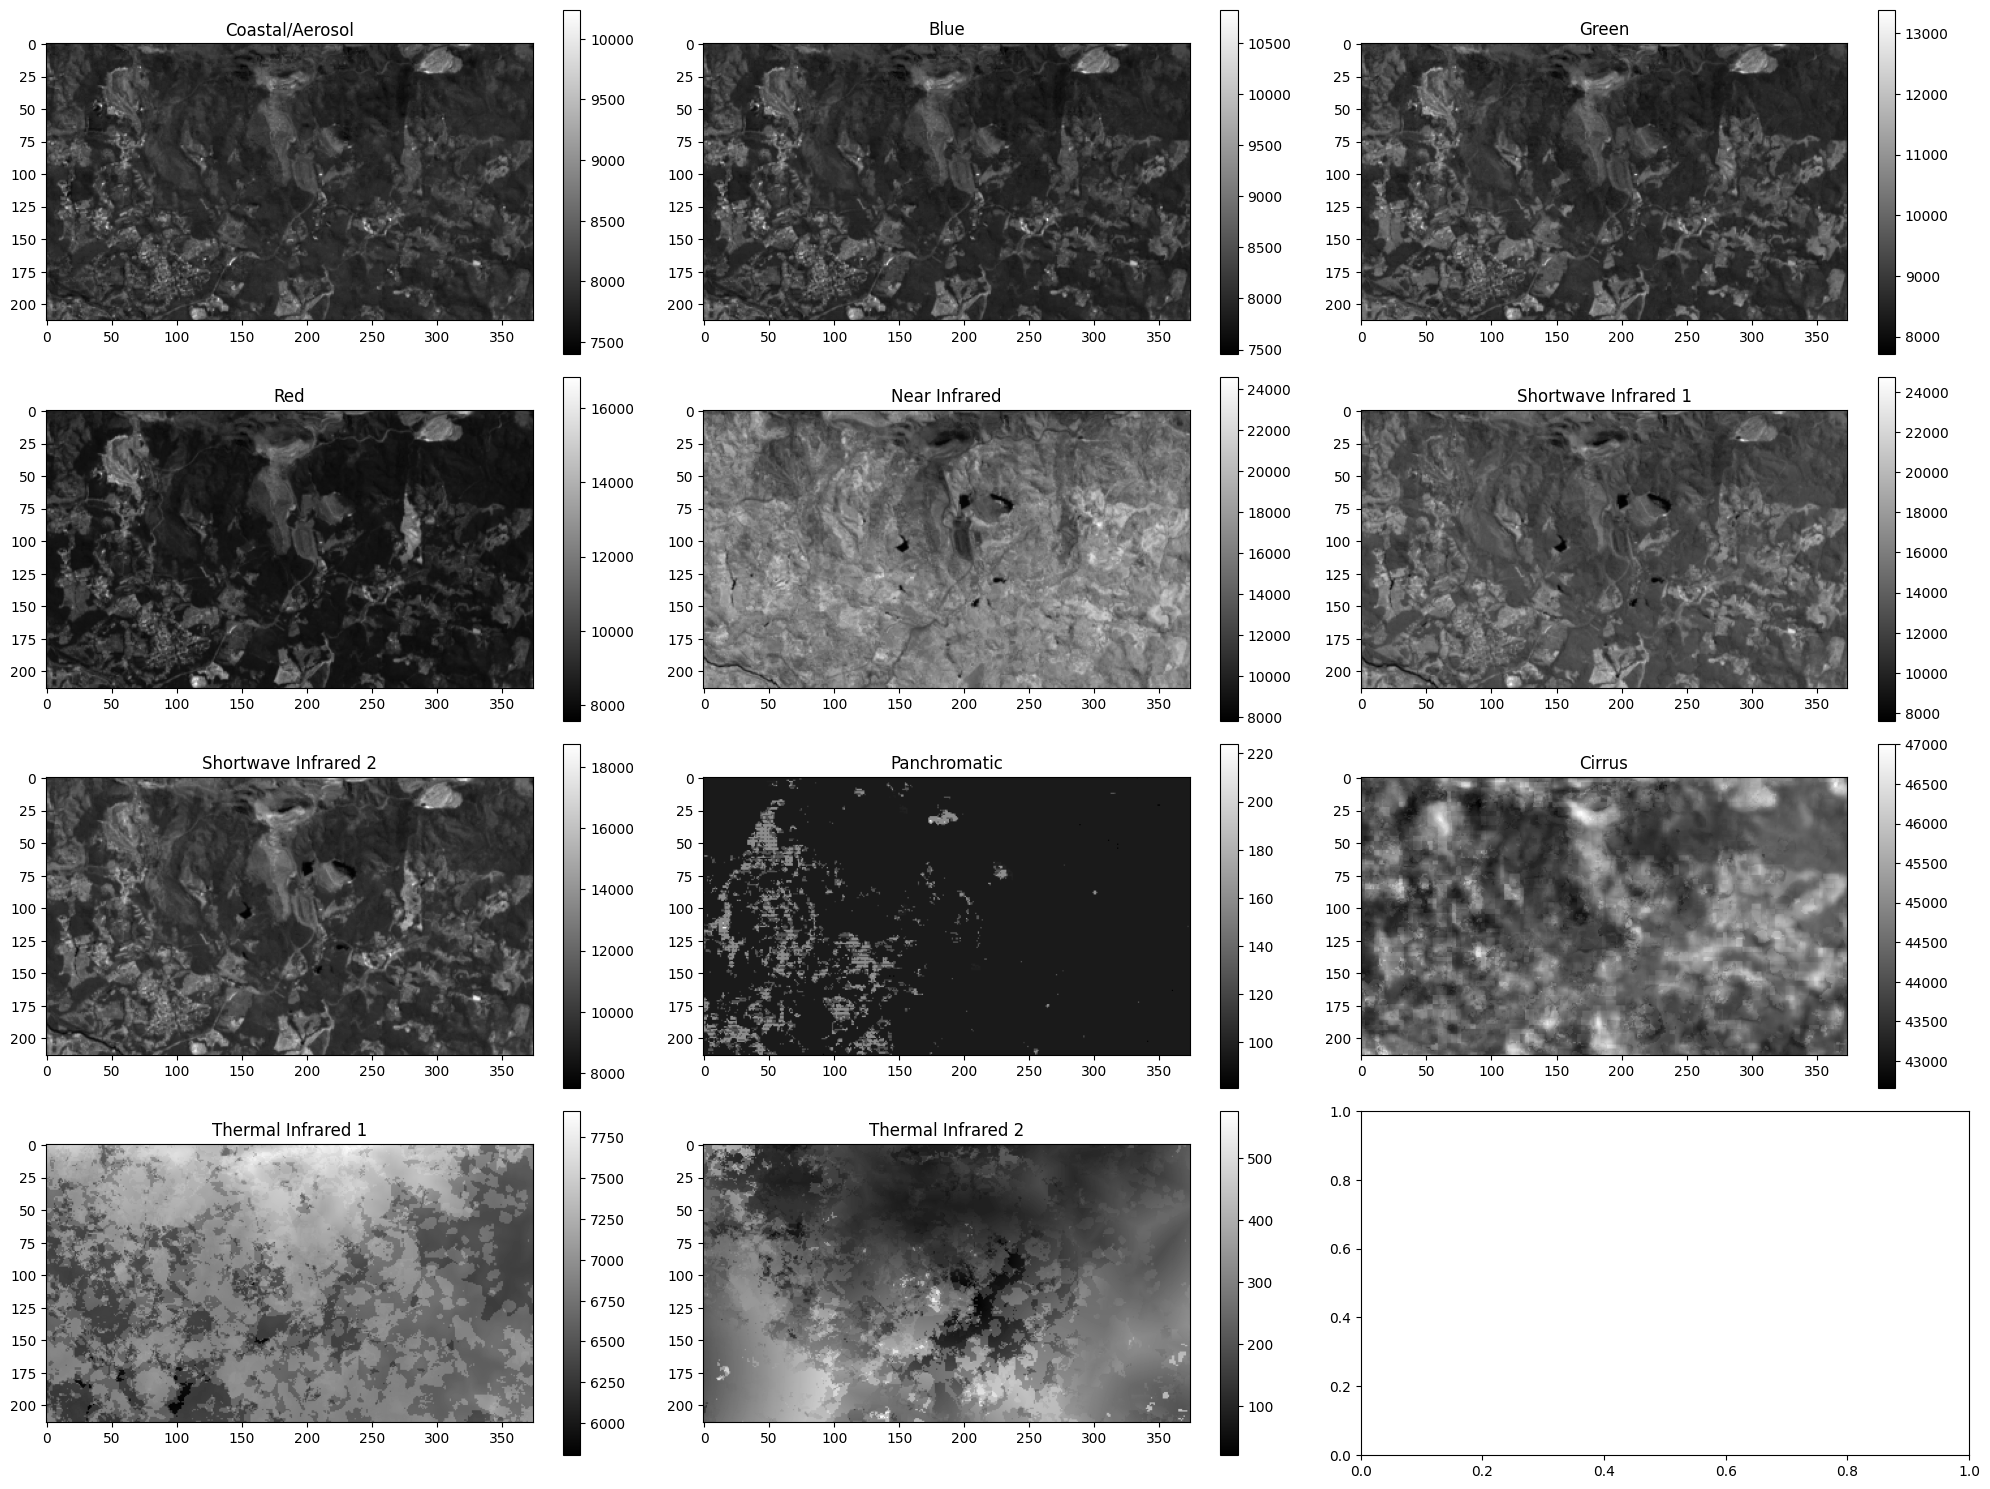

In [ ]:
# Usamos gdal para abrir um arquivo geoespacial específico
ds = gdal.Open('/content/drive/MyDrive/deforestation/2015api.tif')

# Criamos um dicionário que mapeia os números das bandas para seus nomes descritivos
band_names = {
    1: "Coastal/Aerosol",
    2: "Blue",
    3: "Green",
    4: "Red",
    5: "Near Infrared",
    6: "Shortwave Infrared 1",
    7: "Shortwave Infrared 2",
    8: "Panchromatic",
    9: "Cirrus",
    10: "Thermal Infrared 1",
    11: "Thermal Infrared 2",
}

# Criamos uma grade de subplots com 4 linhas e 3 colunas e definimos o tamanho da figura
fig, axs = plt.subplots(4, 3, figsize=(20, 15))

# Iteramos sobre cada banda e nome no dicionário band_names
for band, name in band_names.items():
    # Identificamos o subplot apropriado no qual plotar
    ax = axs[(band - 1) // 3, (band - 1) % 3]
    # Lemos os dados da banda atual como um array e os exibimos na imagem
    im = ax.imshow(ds.GetRasterBand(band).ReadAsArray())
    # Adicionamos uma barra de cores à imagem
    fig.colorbar(im, ax=ax)
    # Definimos o título do subplot com o nome da banda
    ax.set_title(name)

# Usamos tight_layout para garantir que os subplots não se sobreponham
plt.tight_layout()

# Exibimos a figura
plt.show()

In [ ]:
def get_NDVI(ds):
    '''
    Calcula o Índice de Vegetação da Diferença Normalizada (NDVI) para uma imagem.

    Argumentos:
    ds -- Um objeto de conjunto de dados GDAL aberto que representa a imagem

    Retorna:
    ndvi -- Uma matriz numpy representando o NDVI da imagem
    '''
    r = ds.GetRasterBand(4).ReadAsArray()   # Banda Vermelha é a 4ª
    nir = ds.GetRasterBand(5).ReadAsArray() # Banda NIR é a 5ª
    ndvi = (nir - r)/(nir + r)
    ndvi = normalize255(ndvi)
    return ndvi

def normalize255(ndvi):
    '''
    Normaliza uma matriz de NDVI para a faixa de 0 a 255.

    Argumentos:
    ndvi -- Uma matriz numpy representando o NDVI

    Retorna:
    ndvi -- A matriz NDVI normalizada
    '''
    ndvi = ndvi + 1
    ndvi = (ndvi / 2) * 255
    return ndvi

def get_NDVI_mask(ndvi):
    '''
    Cria uma máscara de limiar para áreas de vegetação em uma matriz de NDVI.

    Argumentos:
    ndvi -- Uma matriz numpy representando o NDVI

    Retorna:
    mask -- Uma matriz binária onde os valores de 1 representam vegetação
    '''
    _, mask = cv2.threshold(ndvi, 150, 255, cv2.THRESH_BINARY)
    return mask

def percent_forest(mask):
    '''
    Calcula a porcentagem de pixels de vegetação em uma máscara.

    Argumentos:
    mask -- Uma matriz binária onde os valores de 1 representam vegetação

    Retorna:
    percent -- A porcentagem de pixels de vegetação
    '''
    c = cv2.countNonZero(mask)
    t = mask.shape[0] * mask.shape[1]
    return round((c / t) * 100, 4)

def plot_NDVI(path):
    '''
    Plota o NDVI e a máscara de vegetação de uma imagem e exibe a porcentagem de vegetação.

    Argumentos:
    path -- O caminho para o arquivo da imagem
    '''
    ds = gdal.Open(path)
    ndvi = get_NDVI(ds)
    ndvi_mask = get_NDVI_mask(ndvi)

    year = path.split('.')[0][:4]
    fig = plt.figure(figsize = (20, 5))
    fig = plt.subplot(1, 2, 1)
    plot = plt.imshow(ndvi, cmap = "gray")
    plt.colorbar()
    plt.title(year + ": " + "NDVI")
    plt.xticks([]), plt.yticks([])
    fig = plt.subplot(1, 2, 2)
    plot = plt.imshow(ndvi_mask, cmap = "gray");
    plt.title(str(percent_forest(ndvi_mask)) + "%")
    plt.xticks([]), plt.yticks([])
    plt.show()


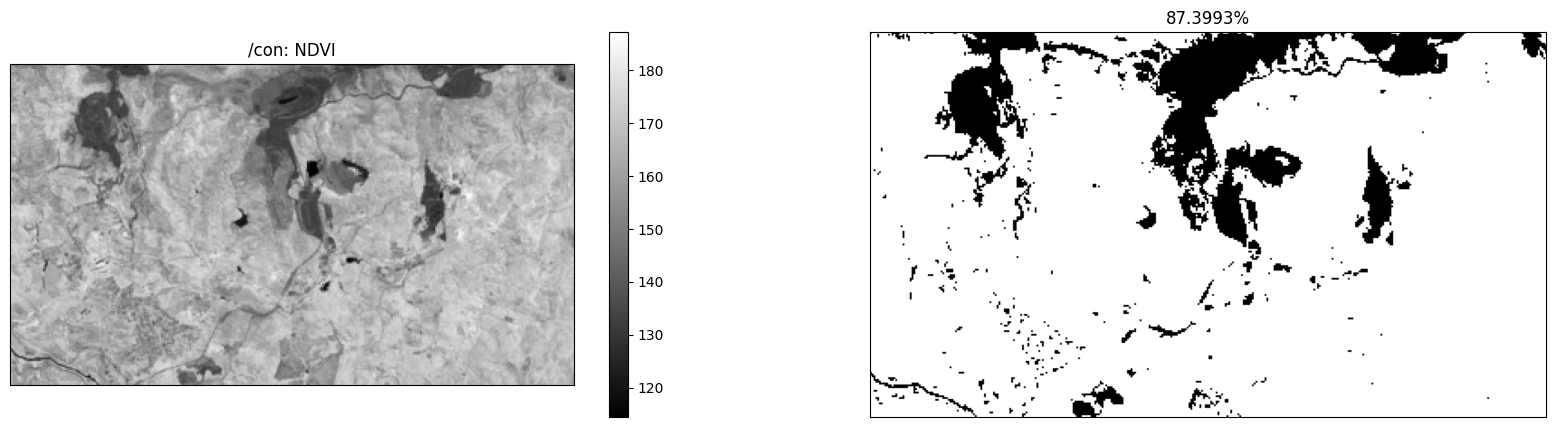

In [ ]:
plot_NDVI("/content/drive/MyDrive/deforestation/2015api.tif")

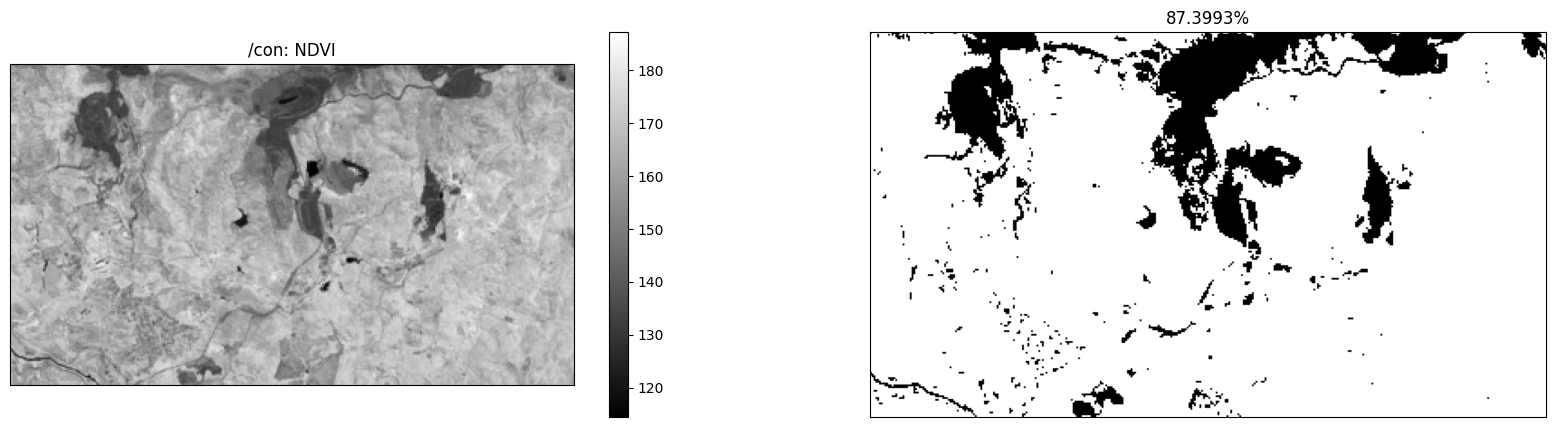

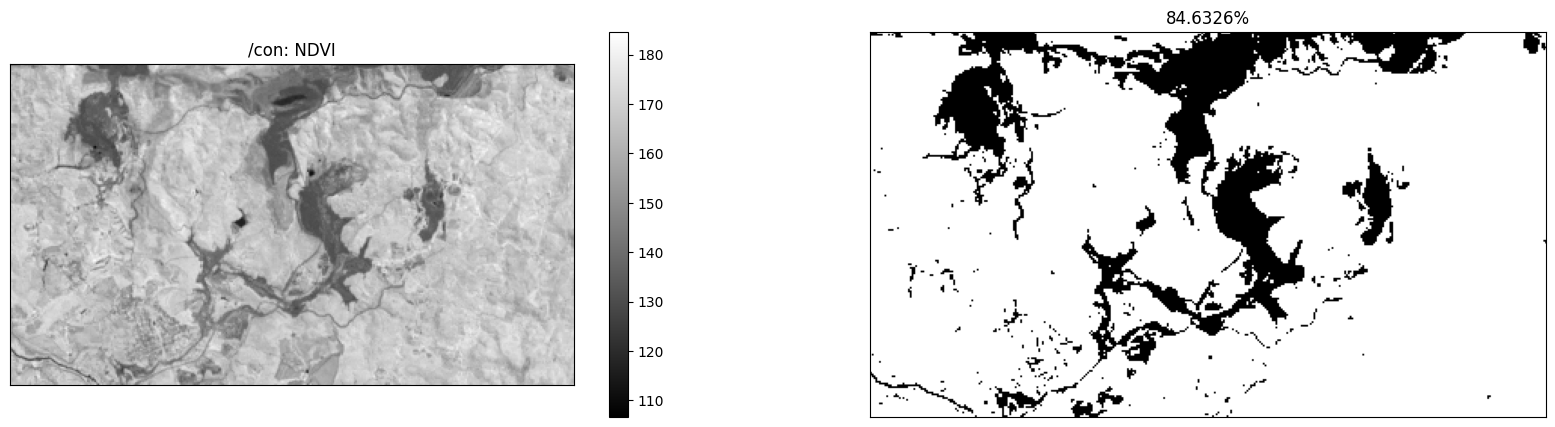

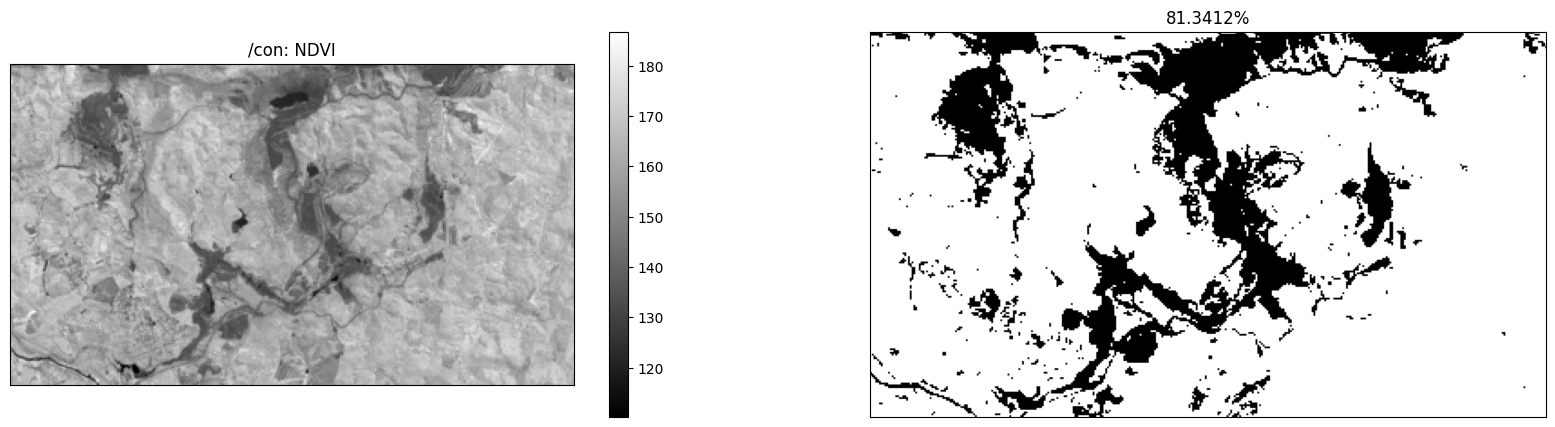

In [ ]:
files = [
    "/content/drive/MyDrive/deforestation/2015api.tif",
    "/content/drive/MyDrive/deforestation/2019api.tif","/content/drive/MyDrive/deforestation/2023api.tif"
]

for file in files:
    plot_NDVI(file)